In [13]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg as nlg
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
from sklearn import linear_model

In [14]:
rawindustryclass = pd.read_excel('STK_INDUSTRYCLASS.xlsx')
rawindustryclass.drop([0,1],inplace=True)  #dataframe删除前两行
rawindustryclass['IndustryClass'] = rawindustryclass['IndustryCode'].apply(lambda x:x[0])  #所属行业大类
idx=rawindustryclass.groupby(['Symbol'])['ImplementDate'].transform(max)  #最新变动日期
industryclass = rawindustryclass[rawindustryclass['ImplementDate'] == idx]  #最新行业类别
Cindustry = industryclass[industryclass['IndustryClass']=='C']  #制造业名单 

In [15]:
rawspecialtreatment = pd.read_excel('SPT_Trdchg.xlsx')
rawspecialtreatment.drop([0,1],inplace=True)  #dataframe删除前两行
twoyearloss = rawspecialtreatment[rawspecialtreatment['Chgreas'] == '01']  #因连续两年亏损被ST的股票名单
twoyearloss['Year'] = twoyearloss['Annoudt'].apply(lambda x:x[0:4])  #被ST年份
twoyearlossindex_2019 = (twoyearloss.groupby('Stkcd')['Year'].min())[(twoyearloss.groupby('Stkcd')['Year'].min() == '2019')].index  #在2019年首次因两年亏损被ST的股票代码
twoyearlossindex_2018 = (twoyearloss.groupby('Stkcd')['Year'].min())[(twoyearloss.groupby('Stkcd')['Year'].min() == '2018')].index  #在2018年首次因两年亏损被ST的股票代码
twoyearloss.set_index('Stkcd',drop=True,inplace=True)
twoyearloss_2019 = twoyearloss.loc[twoyearlossindex_2019]
twoyearloss_2018 = twoyearloss.loc[twoyearlossindex_2018]
Cindustrytwoyearloss_2019 = pd.merge(Cindustry, twoyearloss_2019, left_on='Symbol', right_on='Stkcd')
Cindustrytwoyearloss_2018 = pd.merge(Cindustry, twoyearloss_2018, left_on='Symbol', right_on='Stkcd')
Cindustrytwoyearloss_2019.set_index('Symbol',drop=True,inplace=True)
Cindustrytwoyearloss_2018.set_index('Symbol',drop=True,inplace=True)

<ipython-input-15-6260f89293ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoyearloss['Year'] = twoyearloss['Annoudt'].apply(lambda x:x[0:4])  #被ST年份


In [16]:
specialtreatment = pd.DataFrame(rawspecialtreatment['Stkcd'].drop_duplicates(keep='first',inplace=False))  #所有曾被ST的股票
specialtreatment.columns = ['Symbol']
specialtreatment['label'] = 1
Cindustryspecialtreatment = pd.merge(Cindustry,specialtreatment,how='left')  
healthyCindustry = Cindustryspecialtreatment[Cindustryspecialtreatment.label != 1].drop(['label'], axis=1)  #制造业中从未被ST的股票

In [17]:
financialdata_2016 = pd.read_csv('2016.csv',encoding='ansi')
financialdata_2017 = pd.read_csv('2017.csv',encoding='ansi')
financialdata_2018 = pd.read_csv('2018.csv',encoding='ansi')
financialdata_20162017 = pd.merge(financialdata_2017,financialdata_2016,on='证券代码')
financialdata_20172018 = pd.merge(financialdata_2017,financialdata_2018,on='证券代码')
financialdata_20172018.drop(['证券简称_y','企业规模\r\n[交易日期] 2018-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_y'],axis=1,inplace=True)
financialdata_20172018mean = financialdata_20172018[['证券代码','证券简称_x','企业规模\r\n[交易日期] 2017-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_x']]  #2017、2018财务数据平均值
financialdata_20162017.drop(['证券简称_y','企业规模\r\n[交易日期] 2016-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_y'],axis=1,inplace=True)
financialdata_20162017mean = financialdata_20162017[['证券代码','证券简称_x','企业规模\r\n[交易日期] 2017-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_x']]  #2016、2017财务数据平均值
for i in range(0,25):
    try:  #直接转换为浮点数会报错，因为部分数据含有千分位分隔符
        financialdata_20172018mean[i] = (financialdata_20172018.iloc[0:3132,i+4].astype('float') + financialdata_20172018.iloc[0:3132,i+29].astype('float'))/2
    except:
        financialdata_20172018.iloc[0:3132,i+4] = financialdata_20172018.iloc[0:3132,i+4].str.replace(',', '').astype(float) 
        financialdata_20172018.iloc[0:3132,i+29] = financialdata_20172018.iloc[0:3132,i+29].str.replace(',', '').astype(float)
        financialdata_20172018mean[i] = (financialdata_20172018.iloc[0:3132,i+4].astype('float') + financialdata_20172018.iloc[0:3132,i+29].astype('float'))/2
    try:
        financialdata_20162017mean[i] = (financialdata_20162017.iloc[0:3132,i+4].astype('float') + financialdata_20162017.iloc[0:3132,i+29].astype('float'))/2
    except:
        financialdata_20162017.iloc[0:3132,i+4] = financialdata_20162017.iloc[0:3132,i+4].str.replace(',', '').astype(float)
        financialdata_20162017.iloc[0:3132,i+29] = financialdata_20162017.iloc[0:3132,i+29].str.replace(',', '').astype(float)
        financialdata_20162017mean[i] = (financialdata_20162017.iloc[0:3132,i+4].astype('float') + financialdata_20162017.iloc[0:3132,i+29].astype('float'))/2
financialdata_20172018mean.columns = ['Symbol','Name','Scale','Industryclass'] + ['X{}'.format(i) for i in range(1,26)]
financialdata_20172018mean['Symbol'] = financialdata_20172018mean['Symbol'].apply(lambda x:x[0:6])  
financialdata_20172018mean.dropna(inplace=True)  #剔除数据缺失的股票
financialdata_20162017mean.columns = ['Symbol','Name','Scale','Industryclass'] + ['X{}'.format(i) for i in range(1,26)]
financialdata_20162017mean['Symbol'] = financialdata_20162017mean['Symbol'].apply(lambda x:x[0:6])  
financialdata_20162017mean.dropna(inplace=True)  #剔除数据缺失的股票

<ipython-input-17-d80f19eaf164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financialdata_20172018mean[i] = (financialdata_20172018.iloc[0:3132,i+4].astype('float') + financialdata_20172018.iloc[0:3132,i+29].astype('float'))/2
<ipython-input-17-d80f19eaf164>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financialdata_20162017mean[i] = (financialdata_20162017.iloc[0:3132,i+4].astype('float') + financialdata_20162017.iloc[0:3132,i+29].astype('float'))/2
<ipython-input-17-d80f19eaf164>:24: SettingWit

In [18]:
Ctyl_2019financialdata_20172018mean = pd.merge(financialdata_20172018mean,Cindustrytwoyearloss_2019,on='Symbol')[['Symbol','Name','Scale','Industryclass']+['X{}'.format(i) for i in range(1,26)]]  
Ctyl_2018financialdata_20162017mean = pd.merge(financialdata_20162017mean,Cindustrytwoyearloss_2018,on='Symbol')[['Symbol','Name','Scale','Industryclass']+['X{}'.format(i) for i in range(1,26)]]  
healthyCfinancialdata_20172018mean = pd.merge(financialdata_20172018mean,healthyCindustry,on='Symbol')[['Symbol','Name','Scale','Industryclass']+['X{}'.format(i) for i in range(1,26)]]  #健康股票的财务数据
Ctyl_financialdatamean = pd.concat([Ctyl_2019financialdata_20172018mean,Ctyl_2018financialdata_20162017mean],axis=0,ignore_index=True)  #ST股前两年平均财务指标值
Ctyl_20182019count = Ctyl_financialdatamean.groupby(['Scale','Industryclass']).count()['Symbol'].unstack().fillna(0)  #分类统计
totalsample = Ctyl_financialdatamean  #训练样本
random_state = 1
for i in range(len(Ctyl_20182019count.index)):
    for j in range(len(Ctyl_20182019count.columns)):
        totalsample = totalsample.append(healthyCfinancialdata_20172018mean[healthyCfinancialdata_20172018mean['Scale'] == Ctyl_20182019count.index[i]].sample(n=10*int(Ctyl_20182019count.iloc[i,j]),random_state=random_state, replace=True,axis=0))
totalsample.drop_duplicates(keep='first',inplace=True)  #删除样本中重复出现的股票

In [19]:
df = totalsample[['X{}'.format(i) for i in range(1,26)]]  #用于因子分析的数据

In [20]:
class fa_test:  #定义类，属性为因子分析预检验的结果
    def bartletttest(self,df):
        self.bartlett = calculate_bartlett_sphericity(df)  #Bartlett's Test
    def kmotest(self,df):
        self.kmo = calculate_kmo(df)  #KMO test

In [21]:
trainingfa_test = fa_test()
trainingfa_test.bartletttest(df)
trainingfa_test.kmotest(df)

In [22]:
trainingfa_test.kmo

(array([0.55182876, 0.66380089, 0.20772508, 0.74589199, 0.6369684 ,
        0.6147911 , 0.61461703, 0.651255  , 0.65867479, 0.70156606,
        0.58242896, 0.84409236, 0.86787601, 0.17980913, 0.57728509,
        0.65892283, 0.4755828 , 0.7023045 , 0.59557443, 0.56601434,
        0.7732201 , 0.62873291, 0.71430111, 0.59396588, 0.25751946]),
 0.6523231809860395)

In [23]:
trainingfa_test.bartlett

(3024.250177797001, 0.0)

In [14]:
fa = FactorAnalyzer(rotation=None, n_factors=25)
fa.fit(df)
fa_25_sd = fa.get_factor_variance()
fa_25_df = pd.DataFrame({'特征值': fa_25_sd[0], '方差贡献率': fa_25_sd[1], '方差累计贡献率': fa_25_sd[2]})
fa_25_df

,特征值,方差贡献率,方差累计贡献率
0,6.989141,0.279566,0.279566
1,4.817928,0.192717,0.472283
2,2.389673,0.095587,0.567870
3,1.583839,0.063354,0.631223
4,1.180205,0.047208,0.678431
5,1.029496,0.041180,0.719611
6,0.918407,0.036736,0.756348
7,0.828510,0.033140,0.789488
8,0.740191,0.029608,0.819096
9,0.683338,0.027334,0.846429


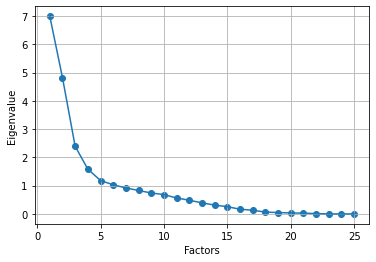

In [17]:
# 可视化碎石图
plt.scatter(range(1,26),fa_25_sd[0])
plt.plot(range(1,26),fa_25_sd[0])
#plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [20]:
fa_6_rotate = FactorAnalyzer(rotation='varimax', n_factors=6)
fa_6_rotate.fit(df)
fa_6_rotate.loadings_  #因子载荷

array([[ 0.22065307, -0.23102268, -0.16037923, -0.0314461 ,  0.06503249,
        -0.7378041 ],
       [ 0.87680844,  0.0122597 , -0.21045544, -0.04090232,  0.10584086,
        -0.29566917],
       [ 0.11256709, -0.17110614, -0.01506669,  0.0490262 ,  0.51435476,
        -0.04184809],
       [ 0.14321199,  0.70284153,  0.2205909 ,  0.53627896,  0.07912574,
         0.08816875],
       [ 0.09065651,  0.86971101,  0.05894756,  0.26529273, -0.13837727,
        -0.06377289],
       [ 0.14806087,  0.37950651,  0.15004471,  0.87097905,  0.15608672,
         0.08783933],
       [ 0.14798873,  0.37897951,  0.15015572,  0.87082115,  0.15550053,
         0.08816222],
       [ 0.94904438,  0.20461485, -0.09330787,  0.07115535,  0.12911608,
         0.04291857],
       [ 0.97719923,  0.1335951 , -0.06315649,  0.05739264,  0.03292126,
         0.07779499],
       [ 0.4819748 ,  0.63393462, -0.07625855,  0.12369979,  0.41872789,
         0.07052023],
       [-0.10018555,  0.07568072,  0.88596417,  0.

In [21]:
fa_6_rotate.get_communalities()  #公因子提取度

array([0.67735372, 0.91353038, 0.31089131, 0.86478598, 0.86168614,
       0.97914394, 0.97835534, 0.97483489, 0.98718452, 0.83559596,
       0.92163647, 0.71373804, 0.97841977, 0.02041633, 0.04355395,
       0.20461431, 0.46073294, 0.98073759, 0.93860634, 0.59677468,
       0.82014712, 0.85376726, 0.37783107, 0.23320928, 0.06046258])

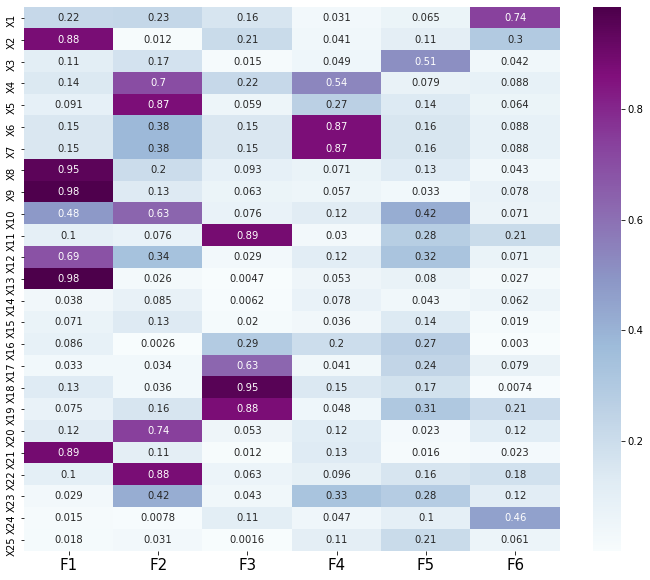

In [28]:
# 可视化因子载荷
df_cm = pd.DataFrame(np.abs(fa_6_rotate.loadings_),index=df.columns)
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(df_cm,annot=True,cmap='BuPu',ax=ax)
ax.set_xticklabels(['F1','F2','F3','F4','F5','F6'])
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)

In [104]:
#因子得分（回归法）
X1 = np.mat(df.corr())
X1 = nlg.inv(X1)
factor_score = np.dot(X1,fa_6_rotate.loadings_)
factor_score = pd.DataFrame(factor_score)
factor_score.columns = ['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']
factor_score.index = df.columns
factor_score

,factor1,factor2,factor3,factor4,factor5,factor6
X1,-0.028362,0.183957,-0.007989,-0.082400,-0.122826,-0.432023
X2,0.274384,-0.413243,0.389066,0.239181,1.445238,-0.786738
X3,0.050139,0.148838,-0.101838,-0.116594,-0.227075,0.152487
X4,0.240459,0.102815,0.120002,-0.210026,-0.384646,0.322056
X5,-0.067183,0.532984,-0.239744,-0.240060,-0.691497,-0.220948
X6,-26.112706,67.506628,-6.407447,45.073475,33.284391,-24.560180
X7,25.954161,-67.799499,6.318040,-43.697599,-32.595518,24.392341
X8,-0.606570,1.869559,-1.540340,-0.367817,0.942144,0.476893
X9,1.621969,-1.379110,1.416920,-0.178799,-1.190546,0.790099
X10,-0.067317,-0.082022,0.371086,0.102672,0.326543,-0.400778


In [42]:
logisticdata = pd.DataFrame(fa_6_rotate.transform(df))  #各股票的因子得分
logisticdata.columns = ['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']
logisticdata['label'] = np.append(np.ones(30),np.zeros(80-30))  #设置label 1代表ST 0代表健康
logisticdata

,factor1,factor2,factor3,factor4,factor5,factor6,label
0,-0.239106,-1.363923,0.161889,-0.821601,-1.372045,0.660990,1.0
1,-0.396880,-0.439319,-0.723466,0.139981,-1.309125,0.128236,1.0
2,-0.808270,-0.354504,-1.213172,-0.175701,1.036462,1.272326,1.0
3,-0.353776,-1.187291,-0.068985,0.073534,-0.671154,0.622418,1.0
4,-0.405931,-1.127064,-0.572196,-0.916877,-0.791101,0.018869,1.0
...,...,...,...,...,...,...,...
75,-0.448360,0.024352,-0.040712,0.362281,-1.280071,0.563235,0.0
76,-0.425971,0.291631,1.549944,0.664781,-1.927603,-0.872163,0.0
77,0.322474,0.075085,1.037324,0.768863,-1.681102,0.105903,0.0
78,-0.179781,0.280788,0.726472,0.399462,-0.357848,-0.244952,0.0


In [65]:
reg = linear_model.LogisticRegression()
reg.fit(logisticdata[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']],logisticdata['label'])

LogisticRegression()

In [66]:
reg.coef_

array([[-0.64082757, -2.13407048, -1.02498037, -2.14682492, -0.28666844,
        -0.76505449]])

In [67]:
reg.intercept_

array([-0.49628256])

In [68]:
probability = reg.predict_proba(logisticdata[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']])[:,1]
fitted = reg.predict(logisticdata[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']])
reg.score(logisticdata[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']],logisticdata['label'])  #回测准确率

0.9375

In [70]:
fitted

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
# 测试

In [98]:
twoyearlossindex_2020 = (twoyearloss.groupby('Stkcd')['Year'].min())[(twoyearloss.groupby('Stkcd')['Year'].min() == '2020')].index
twoyearloss_2020 = twoyearloss.loc[twoyearlossindex_2020]
Cindustrytwoyearloss_2020 = pd.merge(Cindustry, twoyearloss_2020, left_on='Symbol', right_on='Stkcd')
financialdata_2019 = pd.read_csv('2019.csv',encoding='ansi')
financialdata_20182019 = pd.merge(financialdata_2018,financialdata_2019,on='证券代码')
financialdata_20182019.drop(['证券简称_y','企业规模\r\n[交易日期] 2019-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_y'],axis=1,inplace=True)
financialdata_20182019mean = financialdata_20182019[['证券代码','证券简称_x','企业规模\r\n[交易日期] 2018-12-31','所属证监会行业代码\r\n[交易日期] 2020-12-31\r\n[行业级别] 大类行业_x']] 
for i in range(0,25):
    financialdata_20182019mean[i] = (financialdata_20182019.iloc[0:3132,i+4].astype('float') + financialdata_20182019.iloc[0:3132,i+29].astype('float'))/2
financialdata_20182019mean.columns = ['Symbol','Name','Scale','Industryclass'] + ['X{}'.format(i) for i in range(1,26)]
financialdata_20182019mean['Symbol'] = financialdata_20182019mean['Symbol'].apply(lambda x:x[0:6])  
financialdata_20182019mean.dropna(inplace=True)  #剔除数据缺失的股票
Ctyl_2020financialdata_20182019mean = pd.merge(financialdata_20182019mean,Cindustrytwoyearloss_2020,on='Symbol')[['Symbol','Name','Scale','Industryclass']+['X{}'.format(i) for i in range(1,26)]]  #ST股票的财务数据
healthyCfinancialdata_20182019mean = pd.merge(financialdata_20182019mean,healthyCindustry,on='Symbol')[['Symbol','Name','Scale','Industryclass']+['X{}'.format(i) for i in range(1,26)]]  #健康股票的财务数据
testsample = pd.concat([Ctyl_2020financialdata_20182019mean,healthyCfinancialdata_20182019mean])
testsample.drop_duplicates(keep='first',inplace=True)  #去掉测试样本中重复出现的股票

<ipython-input-98-caa609656280>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financialdata_20182019mean[i] = (financialdata_20182019.iloc[0:3132,i+4].astype('float') + financialdata_20182019.iloc[0:3132,i+29].astype('float'))/2
<ipython-input-98-caa609656280>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financialdata_20182019mean['Symbol'] = financialdata_20182019mean['Symbol'].apply(lambda x:x[0:6])
D:\anaconda\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is t

In [99]:
dftest = testsample[['X{}'.format(i) for i in range(1,26)]]  #用于因子分析的测试数据
testfactorscore = pd.DataFrame(fa_6_rotate.transform(testsample[['X{}'.format(i) for i in range(1,26)]]))
testfactorscore.columns = ['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']
testpredict = reg.predict(testfactorscore[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']])
reg.score(testfactorscore[['factor1', 'factor2', 'factor3', 'factor4', 'factor5','factor6']],[1]*35+[0]*(1297-35))  #测试样本预测准确率

0.9452582883577486